In [3]:
#!/usr/bin/env python
import numpy as np
import itertools
import ROOT
from ROOT import TChain, AddressOf, std
from array import array
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_jet_rings(jet_eta,jet_phi,tau_tagged):
    """
    Function for graphing circles displaying the core (R=0.1), central (R=0.2) and outer (R=0.4) regions of the jet
    """
    theta = np.linspace(0, 2*np.pi, 100)
    radius_core = 0.1
    a_core = radius_core*np.cos(theta) + jet_eta
    b_core = radius_core*np.sin(theta) + jet_phi

    radius_cent = 0.2
    a_cent = radius_cent*np.cos(theta) + jet_eta
    b_cent = radius_cent*np.sin(theta) + jet_phi

    radius_out = 0.4
    a_out = radius_out*np.cos(theta) + jet_eta
    b_out = radius_out*np.sin(theta) + jet_phi
    if tau_tagged == 0: 
        plt.plot(a_core, b_core, 'r')
        plt.plot(a_cent, b_cent, 'r')
        plt.plot(a_out, b_out, 'r')
        plt.plot(jet_eta, jet_phi, 'r')
    else:
        plt.plot(a_core, b_core, 'y')
        plt.plot(a_cent, b_cent, 'y')
        plt.plot(a_out, b_out, 'y')
        plt.plot(jet_eta, jet_phi, 'y')

def evt_display(filename,  evt_id, title, output, jet_idxs = 'None', font_size=16, save_fig=True):
    '''
    filename: root ntuple with jet data
    evt_id: which event you want to display
    title: title of graph
    output: file destination to save display
    jet_idxs: optional argument for which jets in event to display
    '''
    plt.rcParams['font.size'] = str(font_size)
    tree_name = "output"
    chain = ROOT.TChain(tree_name, tree_name) 
    chain.Add(filename)
    chain.GetEntry(evt_id)
    ax = plt.gca() #you first need to get the axis handle
    ax.set_aspect(1)
    fig = plt.gcf()
    fig.set_size_inches(12, 12)
    if jet_idxs == 'None':
        pt = list(chain.TowerEt) + list(chain.TrackPt)
        mini, maxi = min(pt), max(pt)
        norm = plt.Normalize(mini, maxi)
        cm = plt.cm.get_cmap('Blues_r')
        plt.scatter(chain.TowerEta,chain.TowerPhi, linewidths = 0.1, s=36, norm=norm, c=chain.TowerEt, cmap=cm, label = 'towers')
        plt.scatter( chain.TrackEta,chain.TrackPhi, marker = 'x', s=36,norm=norm, c=chain.TrackPt, cmap=cm, label = 'tracks')
        
        tower_phi = []
        tower_eta = []
        track_phi = []
        track_eta = []
        last_tower_idx = 0 
        last_track_idx = 0 #keeps track of last final index for tracks and towers
        #this for loop splits up all of the tower/track phi and eta data into different lists for each jet, compiles together as list of lists
        for jet_id in range(chain.nJets):
            plot_jet_rings(chain.JetEta[jet_id],chain.JetPhi[jet_id], chain.TruthJetIsTautagged[jet_id])
        plt.title(title)
        plt.xlabel('Pseudorapiditiy ($\eta$)',fontsize = 16)
        plt.ylabel('Azimuthal angle ($\phi$)', fontsize = 16)
        plt.colorbar(ax = ax, shrink = 0.5)
        plt.tight_layout()
        plt.savefig(output)
        plt.show()
        
    else:
        tower_phi = []
        tower_eta = []
        tower_Et = []
        track_phi = []
        track_eta = []
        track_pt = []
        last_tower_idx = 0 
        last_track_idx = 0 #keeps track of last final index for tracks and towers
        #this for loop splits up all of the tower/track phi and eta data into different lists for each jet, compiles together as list of lists
        for jet_id in range(chain.nJets):
            jet_tower_n = chain.JetTowerN[jet_id]
            tower_phi.append(chain.JetTowerPhi[last_tower_idx:last_tower_idx+jet_tower_n])
            tower_eta.append(chain.JetTowerEta[last_tower_idx:last_tower_idx+jet_tower_n])
            tower_Et.append(chain.JetTowerEt[last_tower_idx:last_tower_idx+jet_tower_n])
            last_tower_idx += jet_tower_n

            jet_track_n = chain.JetGhostTrackN[jet_id]
            jet_track_idxs = chain.JetGhostTrackIdx[last_track_idx:last_track_idx+jet_track_n]

            jet_track_eta = []
            jet_track_phi = []
            jet_track_pt = []
            for jet_track_idx in jet_track_idxs:
                jet_track_eta.append(chain.TrackEta[jet_track_idx])
                jet_track_phi.append(chain.TrackPhi[jet_track_idx])
                jet_track_pt.append(chain.TrackPt[jet_track_idx])
            track_eta.append(jet_track_eta)
            track_phi.append(jet_track_phi)
            track_pt.append(jet_track_pt)
            last_track_idx += jet_track_n

        colors = [(0.6, 0.8, 1.0), (0, 0.2, 0.5)] # Experiment with this
        cm = mpl.colors.LinearSegmentedColormap.from_list('test', colors)
        #now, looks at each jet_idx given to function on plots that jet and it's associated towers and tracks
        for jet_idx in jet_idxs:
            plot_jet_rings(chain.JetEta[jet_idx],chain.JetPhi[jet_idx], chain.TruthJetIsTautagged[jet_idx])
            
            pt = list(tower_Et[jet_idx]) + list(track_pt[jet_idx])
            mini, maxi = min(pt), max(pt)
            norm = plt.Normalize(mini, maxi)
            plt.scatter(tower_eta[jet_idx],tower_phi[jet_idx],  marker ='o', linewidths = 0.5, s=36, norm=norm, c=tower_Et[jet_idx], cmap=cm, label = 'towers')
            plt.scatter(track_eta[jet_idx],track_phi[jet_idx],   marker ='x', norm=norm, s=36, c=track_pt[jet_idx], cmap=cm, label = 'tracks')

        #finishes plotting the graph
        plt.title(title)
        plt.xlabel('Pseudorapiditiy ($\eta$)')
        plt.ylabel('Azimuthal angle ($\phi$)')
        plt.colorbar(ax = ax, shrink = 0.5)
        plt.tight_layout()
        plt.legend()
        if save_fig:
            plt.savefig(output)
        plt.show()

In [4]:
filename_tau_pileup = '/global/cfs/cdirs/m3443/data/TauStudies/v5/ditau_train.root'
filename_qcd_pileup = '/global/cfs/cdirs/m3443/data/TauStudies/v5/qcd_train.root'

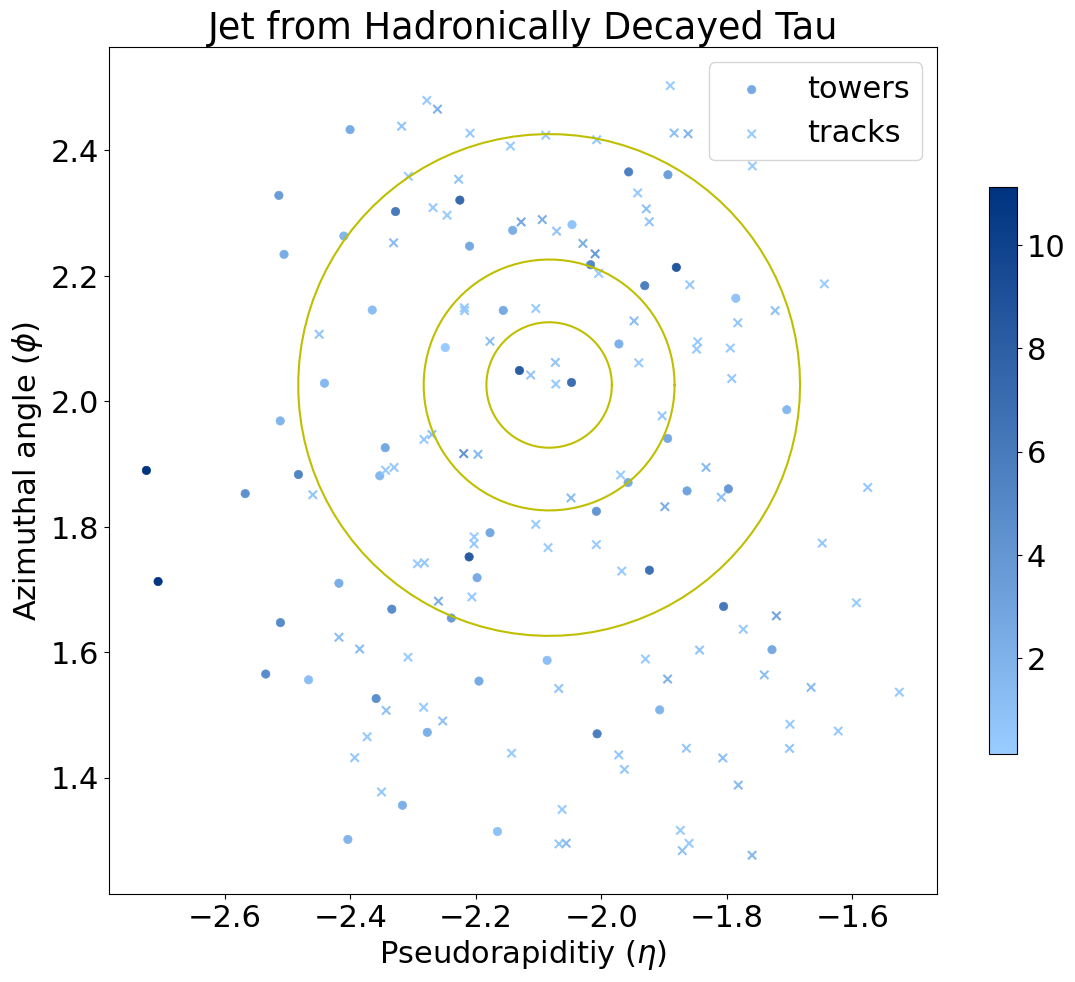

In [8]:
evt_display(filename_tau_pileup, 4, 'Jet from Hadronically Decayed Tau', 'tau_jet.pdf',[0], save_fig=True, font_size=22)

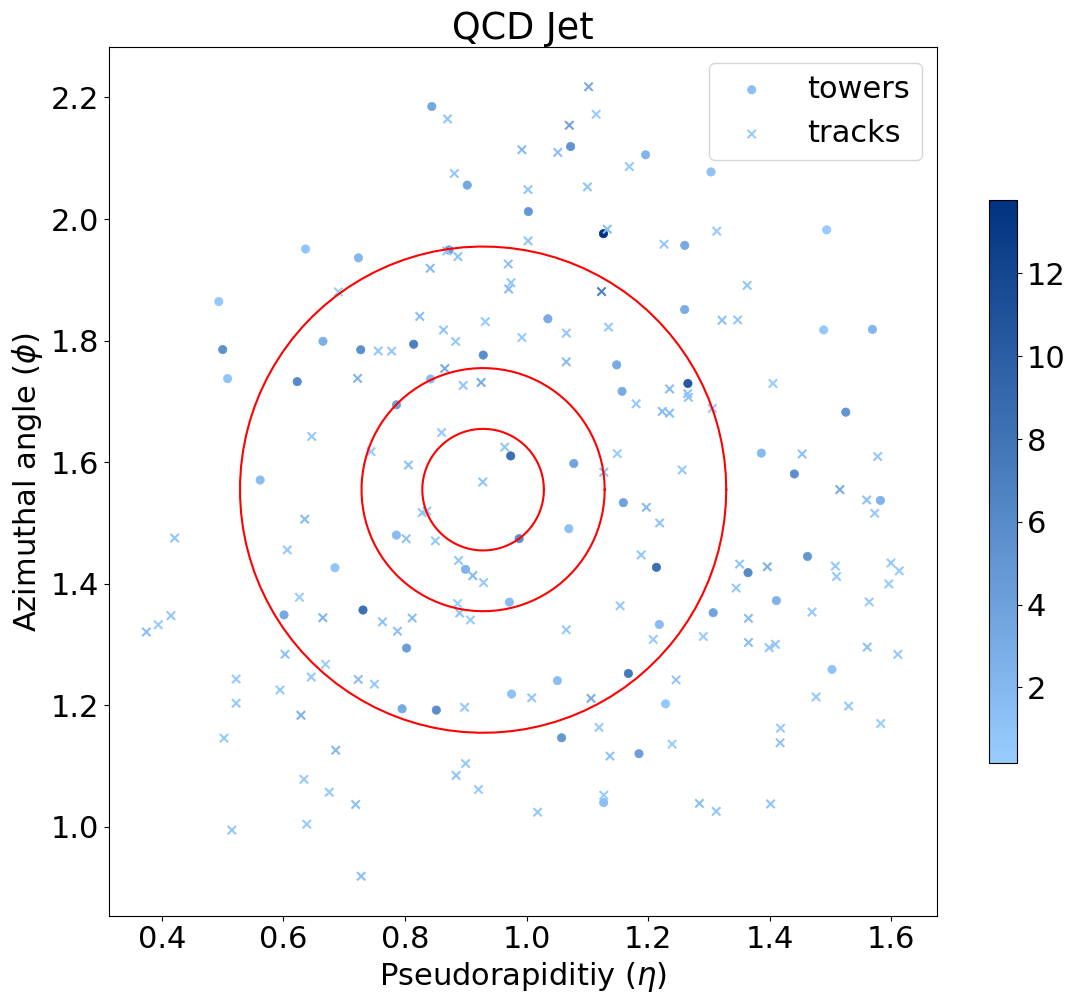

In [10]:
evt_display(filename_qcd_pileup, 4, 'QCD Jet', 'qcd_jet.pdf',[0], font_size=22)